In [1]:
import os
import numpy as np
from astropy.io import ascii
from scipy.interpolate import interp1d
import xidplus
temps=os.listdir('/Users/pdh21/astrodata/SEDs/Berta2013/templates_berta_norm_LIR/')

In [72]:
temps

['Blue_SF_glx.norm_LIR',
 'BroadFIR_SF_glx.norm_LIR',
 'Cold_glx.norm_LIR',
 'Elliptical.norm_LIR',
 'Ly_break.norm_LIR',
 'MIR_powlaw_SF_glx.norm_LIR',
 'MIRex_SF_glx.norm_LIR',
 'Mod_SF_glx.norm_LIR',
 'Obs_SF_glx.norm_LIR',
 'PAH_DF_glx.norm_LIR',
 'Red_SF_glx_1.norm_LIR',
 'Red_SF_glx_2.norm_LIR',
 'Secular_glx.norm_LIR',
 'SF_glx_1.norm_LIR',
 'SF_glx_2.norm_LIR',
 'SF_Type1_AGN_1.norm_LIR',
 'SF_Type1_AGN_2.norm_LIR',
 'SF_Type1_AGN_3.norm_LIR',
 'SF_Type1_AGN_4.norm_LIR',
 'SF_Type2_AGN_1.norm_LIR',
 'SF_Type2_AGN_2.norm_LIR',
 'SF_Type2_AGN_3.norm_LIR',
 'Si_break.norm_LIR',
 'Spiral.norm_LIR',
 'Torus.norm_LIR',
 'Type1_AGN_1.norm_LIR',
 'Type2_AGN_1.norm_LIR',
 'Type2_AGN_2.norm_LIR',
 'Warm_SF_glx.norm_LIR',
 'WeakPAH_SF_glx_1.norm_LIR',
 'WeakPAH_SF_glx_2.norm_LIR',
 'Young_SF_glx.norm_LIR']

Generate Redshift Grid and convert to denominator for flux conversion (e.g. $4 \pi D_l^2)$

In [3]:
red=np.arange(0,8,0.01)
red[0]=0.000001
from astropy.cosmology import Planck13
import astropy.units as u
div=(4.0*np.pi * np.square(Planck13.luminosity_distance(red).cgs))
div=div.value

Get appropriate filters

In [4]:
from xidplus import filters
filter=filters.FilterFile(file=xidplus.__path__[0]+'/../test_files/filters.res')

In [5]:
filter.names()

    1 Koo-Kron U+ filter (Koo's thesis) - 0001
    2 Koo-Kron J+ filter (Koo's thesis) - 0002
    3 Koo-Kron F+ filter (Koo's thesis) - 0003
    4 Koo-Kron N+ filter (Koo's thesis) - 0004
    5 Koo-Kron R band (=127+RG610, data from Koo, Durham) - 0005
    6 Couch and Newell (80) BJ (photographic) filter - 0006
    7 Couch and Newell (80) RF (photographic) filter - 0007
    8 Koo-Kron U+ filter (Bruzual's thesis) - 0008
    9 Koo-Kron J+ filter (Bruzual's thesis) - 0009
   10 Koo-Kron F+ filter (Bruzual's thesis) - 0010
   11 Koo-Kron N+ filter (Bruzual's thesis) - 0011
   12 Buser's U filter - 0012
   13 Buser's B2 filter - 0013
   14 Buser's B3 filter - 0014
   15 Buser's V filter - 0015
   16 Matthews and Sandage U filter - 0016
   17 Matthews and Sandage B filter - 0017
   18 Matthews and Sandage V filter - 0018
   19 Sandage and Smith B filter - 0019
   20 Sandage and Smith V filter - 0020
   21 Sandage and Smith R filter - 0021
   22 ST-UV14 filter - 0022
   23 ST-UV17 filter - 0

In [6]:

SPIRE_250=filter.filters[215]
SPIRE_350=filter.filters[216]
SPIRE_500=filter.filters[217]
MIPS_24=filter.filters[201]
PACS_100=filter.filters[250]
PACS_160=filter.filters[251]

bands=[SPIRE_250,SPIRE_350,SPIRE_500,MIPS_24,PACS_100,PACS_160]
eff_lam=[250.0,350.0,500.0,24.0, 100.0,160.0]

In [7]:
for b in bands:
    print(b.name)

SPIRE 250 micron - 0216
SPIRE 350 micron - 0217
SPIRE 500 micron - 0218
Spitzer MIPS CH1 (24 microns) - 0202
PACS 100 Instrument Simulator as of Herschel Launch - 0251
PACS 160 Instrument Simulator as of Herschel Launch - 0252


In [8]:
import pandas as pd
template=ascii.read('/Users/pdh21/astrodata/SEDs/Berta2013/templates_berta_norm_LIR/'+temps[0])
df=pd.DataFrame(template['col1'].data/1E4,columns=['wave'])
print(template['col1'].data/1E4)
SEDs=np.empty((len(temps),len(bands),red.size))
for i in range(0,len(temps)):
    template=ascii.read('/Users/pdh21/astrodata/SEDs/Berta2013/templates_berta_norm_LIR/'+temps[i])
    df[temps[i]]=1E30*3.826E33*template['col2']*((template['col1']/1E4)**2)/3E14
    
    flux=template['col2']*((template['col1']/1E4)**2)/3E14
    wave=template['col1']/1E4

    for z in range(0,red.size):
        sed=interp1d((red[z]+1.0)*wave, flux)
        for b in range(0,len(bands)):
            SEDs[i,b,z]=1E30*3.826E33*(1.0+red[z])*filters.fnu_filt(sed(bands[b].wavelength/1E4),3E8/(bands[b].wavelength/1E10),bands[b].transmission,3E8/(eff_lam[b]*1E-6),sed(eff_lam[b]))/div[z]
        

[  9.09999900e-03   9.40000000e-03   9.59999900e-03 ...,   1.92899989e+03
   1.93899920e+03   1.94899898e+03]


(0.0001, 10000.0)

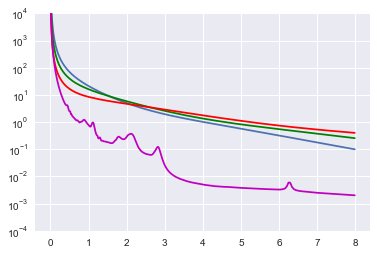

In [13]:
import pylab as plt
%matplotlib inline
plt.semilogy(red,SEDs[0,0,:]*np.power(10.0,12))
plt.semilogy(red,SEDs[0,1,:]*np.power(10.0,12),c='g')
plt.semilogy(red,SEDs[0,2,:]*np.power(10.0,12),c='r')
plt.semilogy(red,SEDs[0,3,:]*np.power(10.0,12),c='m')

plt.ylim(1E-4,1E4)

In [36]:
np.save('SED_IR', SEDs)

In [12]:
ls

SEDS_Herschel_full.pkl
SEDS_full.pkl
SED_Herschel.npy
SED_SPIRE_PACS100.npy
SED_prior_model.ipynb
XID+SPIRE.pkl
XID+example_run_script.ipynb
XID+example_run_script_SED.ipynb
XID+posterior_analysis_validation.ipynb
foo.html
test.fits
test.pkl


In [37]:
df.to_pickle('SEDS_IR_full.pkl')

In [9]:
from bokeh.io import output_notebook, show
from bokeh.layouts import gridplot, column
from bokeh.plotting import figure
from bokeh.io import push_notebook
output_notebook()
from bokeh.models import HoverTool, Range1d

from bokeh.models import ColumnDataSource, DataSource
from bokeh.models import CustomJS, ColumnDataSource, Slider


Loading BokehJS ...

In [22]:
from ipywidgets import interact
import numpy as np

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()


plot_options = dict(width=250, plot_height=250)

LIR=12

# create a new plot
source = ColumnDataSource(
        data=dict(
            x=SEDs[:,0,200]*10.0**LIR,
            y=SEDs[:,1,200]*10.0**LIR,
            z=SEDs[:,2,200]*10.0**LIR,
            width=(SEDs[:,0,200]*10.0**LIR)/5.0,
            height=(SEDs[:,1,200]*10.0**LIR)/5.0,
            depth=(SEDs[:,2,200]*10.0**LIR)/5.0,
            desc=temps,
        )
    )

hover1 = HoverTool(
        tooltips=[
            ("SED", "@desc"),
        ]
    )
hover2 = HoverTool(
        tooltips=[
            ("SED", "@desc"),
        ]
    )
hover3 = HoverTool(
        tooltips=[
            ("SED", "@desc"),
        ]
    )
s1 = figure(**plot_options,tools=[hover1, 'pan', 'wheel_zoom'])
s1.circle('x', 'y', size=10, source=source,color="navy", alpha=0.0)

s1.ellipse('x', 'y', height='height',width='width', source=source,color="navy", alpha=0.2)
s1.yaxis.axis_label = r'350'

# create a new plot and share both ranges
s2 = figure(x_range=s1.x_range, **plot_options,tools=[hover2, 'pan', 'wheel_zoom'])
s2.circle('x', 'z', size=10, source=source,color="navy", alpha=0.0)

s2.ellipse('x', 'z',height='depth',width='width' , source=source,color="navy", alpha=0.2)
s2.yaxis.axis_label = r'500'
s2.xaxis.axis_label = r'250'


# create a new plot and share only one range
s3 = figure(x_range=s1.y_range,y_range=s2.y_range, **plot_options,tools=[hover3, 'pan', 'wheel_zoom'])
s3.circle('y', 'z', size=10, source=source,color="navy", alpha=0.0)
s3.ellipse('y', 'z',height='depth',width='height', source=source,color="navy", alpha=0.2)
s3.xaxis.axis_label = r'350'

p = gridplot([[s1,],[s2, s3]])

def update(LIR=12,z=red[200]):
    ind=np.long(z*100)
    print(ind)
    source.data['x']=SEDs[:,0,ind]*10.0**LIR
    source.data['y']=SEDs[:,1,ind]*10.0**LIR
    source.data['z']=SEDs[:,2,ind]*10.0**LIR
    source.data['width']=np.full(SEDs.shape[0],np.std(SEDs[:,0,ind]*10.0**LIR))
    source.data['depth']=np.full(SEDs.shape[0],np.std(SEDs[:,1,ind]*10.0**LIR))
    source.data['height']=np.full(SEDs.shape[0],np.std(SEDs[:,2,ind]*10.0**LIR))
    push_notebook()


show(p, notebook_handle=True)
interact(update,LIR=(8,14,0.01),z=(red[0],red[-1],0.01))








Loading BokehJS ...

<function __main__.update>

In [66]:
from ipywidgets import interact
import numpy as np

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()


plot_options = dict(width=250, plot_height=250)

LIR=12

# create a new plot
source = ColumnDataSource(
        data=dict(
            s250=SEDs[:,0,200]*10.0**LIR,
            s350=SEDs[:,1,200]*10.0**LIR,
            s500=SEDs[:,2,200]*10.0**LIR,
            s24=SEDs[:,3,200]*10.0**LIR,
            s100=SEDs[:,4,200]*10.0**LIR,
            s160=SEDs[:,5,200]*10.0**LIR,
            s250_sig=0.3*SEDs[:,0,200]*10.0**LIR,
            s350_sig=0.3*SEDs[:,1,200]*10.0**LIR,
            s500_sig=0.3*SEDs[:,2,200]*10.0**LIR,
            s24_sig=0.3*SEDs[:,3,200]*10.0**LIR,
            s100_sig=0.3*SEDs[:,4,200]*10.0**LIR,
            s160_sig=0.3*SEDs[:,5,200]*10.0**LIR,
            desc=temps,
        )
    )


hover=[]
for i in range(0,10):
    hover.append(HoverTool(
        tooltips=[
            ("SED", "@desc"),
        ]
    ))

  
s0_0 = figure(**plot_options,tools=[hover[0], 'pan', 'wheel_zoom'])
s0_0.circle('s100', 's160', size=10, source=source,color="navy", alpha=0.0)

s0_0.ellipse('s100', 's160', height='s160_sig',width='s100_sig', source=source,color="navy", alpha=0.2)
s0_0.yaxis.axis_label = r'160'

# create a new plot and share both ranges
s0_1 = figure(x_range=s0_0.x_range, **plot_options,tools=[hover[1], 'pan', 'wheel_zoom'])
s0_1.circle('s100', 's250', size=10, source=source,color="navy", alpha=0.0)

s0_1.ellipse('s100', 's250',height='s250_sig',width='s100_sig' , source=source,color="navy", alpha=0.2)
s0_1.yaxis.axis_label = r'250'

s0_2 = figure(x_range=s0_0.x_range, **plot_options,tools=[hover[2], 'pan', 'wheel_zoom'])
s0_2.circle('s100', 's350', size=10, source=source,color="navy", alpha=0.0)

s0_2.ellipse('s100', 's350',height='s350_sig',width='s100_sig' , source=source,color="navy", alpha=0.2)
s0_2.yaxis.axis_label = r'350'

s0_3 = figure(x_range=s0_0.x_range, **plot_options,tools=[hover[3], 'pan', 'wheel_zoom'])
s0_3.circle('s100', 's500', size=10, source=source,color="navy", alpha=0.0)

s0_3.ellipse('s100', 's500',height='s500_sig',width='s100_sig' , source=source,color="navy", alpha=0.2)
s0_3.yaxis.axis_label = r'500'
s0_3.xaxis.axis_label = r'100'

s1_1 = figure(x_range=s0_0.y_range,y_range=s0_1.y_range, **plot_options,tools=[hover[4], 'pan', 'wheel_zoom'])
s1_1.circle('s160', 's250', size=10, source=source,color="navy", alpha=0.0)

s1_1.ellipse('s160', 's250',height='s250_sig',width='s160_sig' , source=source,color="navy", alpha=0.2)
s1_1.yaxis.axis_label = r'250'

s1_2 = figure(x_range=s0_0.y_range,y_range=s0_2.y_range, **plot_options,tools=[hover[5], 'pan', 'wheel_zoom'])
s1_2.circle('s160', 's350', size=10, source=source,color="navy", alpha=0.0)

s1_2.ellipse('s160', 's350',height='s350_sig',width='s160_sig' , source=source,color="navy", alpha=0.2)
s1_2.yaxis.axis_label = r'350'

s1_3 = figure(x_range=s0_0.y_range,y_range=s0_3.y_range, **plot_options,tools=[hover[6], 'pan', 'wheel_zoom'])
s1_3.circle('s160', 's500', size=10, source=source,color="navy", alpha=0.0)

s1_3.ellipse('s160', 's500',height='s500_sig',width='s160_sig' , source=source,color="navy", alpha=0.2)
s1_3.yaxis.axis_label = r'500'
s1_3.xaxis.axis_label = r'160'

s2_2 = figure(x_range=s0_1.y_range,y_range=s0_2.y_range, **plot_options,tools=[hover[7], 'pan', 'wheel_zoom'])
s2_2.circle('s250', 's350', size=10, source=source,color="navy", alpha=0.0)

s2_2.ellipse('s250', 's350',height='s350_sig',width='s250_sig' , source=source,color="navy", alpha=0.2)
s2_2.yaxis.axis_label = r'350'

s2_3 = figure(x_range=s0_1.y_range,y_range=s0_3.y_range, **plot_options,tools=[hover[8], 'pan', 'wheel_zoom'])
s2_3.circle('s250', 's500', size=10, source=source,color="navy", alpha=0.0)

s2_3.ellipse('s250', 's500',height='s500_sig',width='s250_sig' , source=source,color="navy", alpha=0.2)
s2_3.yaxis.axis_label = r'500'
s2_3.xaxis.axis_label = r'250'

s3_3 = figure(x_range=s0_2.y_range,y_range=s0_3.y_range, **plot_options,tools=[hover[9], 'pan', 'wheel_zoom'])
s3_3.circle('s350', 's500', size=10, source=source,color="navy", alpha=0.0)

s3_3.ellipse('s350', 's500',height='s500_sig',width='s350_sig' , source=source,color="navy", alpha=0.2)
s3_3.yaxis.axis_label = r'500'
s3_3.xaxis.axis_label = r'350'



p = gridplot([[s0_0,],[s0_1,s1_1,],[s0_2,s1_2,s2_2,],[s0_3,s1_3,s2_3,s3_3]])

def update(LIR=12,z=red[200]):
    ind=np.long(z*100)
    print(ind)
    source.data['s250']=SEDs[:,0,ind]*10.0**LIR
    source.data['s350']=SEDs[:,1,ind]*10.0**LIR
    source.data['s500']=SEDs[:,2,ind]*10.0**LIR
    source.data['s100']=SEDs[:,3,ind]*10.0**LIR
    source.data['s160']=SEDs[:,4,ind]*10.0**LIR
    
    
    source.data['s250_sig']=0.3*SEDs[:,0,ind]*10.0**LIR
    source.data['s350_sig']=0.3*SEDs[:,1,ind]*10.0**LIR
    source.data['s500_sig']=0.3*SEDs[:,2,ind]*10.0**LIR
    source.data['s100_sig']=0.3*SEDs[:,3,ind]*10.0**LIR
    source.data['s160_sig']=0.3*SEDs[:,4,ind]*10.0**LIR
    push_notebook()


show(p, notebook_handle=True)
interact(update,LIR=(8,14,0.01),z=(red[0],red[-1],0.01))








Loading BokehJS ...

<function __main__.update>

In [84]:
####log 10 version
from ipywidgets import interact
import numpy as np

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()


plot_options = dict(width=250, plot_height=250)

LIR=12

# create a new plot
source = ColumnDataSource(
        data=dict(
            s250=np.log10(SEDs[:,0,200]*10.0**LIR),
            s350=np.log10(SEDs[:,1,200]*10.0**LIR),
            s500=np.log10(SEDs[:,2,200]*10.0**LIR),
            s100=np.log10(SEDs[:,3,200]*10.0**LIR),
            s160=np.log10(SEDs[:,4,200]*10.0**LIR),
            s250_sig=np.full(SEDs.shape[0],sig[0,200]),
            s350_sig=np.full(SEDs.shape[0],sig[1,200]),
            s500_sig=np.full(SEDs.shape[0],sig[2,200]),
            s100_sig=np.full(SEDs.shape[0],sig[3,200]),
            s160_sig=np.full(SEDs.shape[0],sig[4,200]),
            desc=temps,
        )
    )


hover=[]
for i in range(0,10):
    hover.append(HoverTool(
        tooltips=[
            ("SED", "@desc"),
        ]
    ))

  
s0_0 = figure(**plot_options,tools=[hover[0], 'pan', 'wheel_zoom'])
s0_0.circle('s100', 's160', size=10, source=source,color="navy", alpha=0.0)

s0_0.ellipse('s100', 's160', height='s160_sig',width='s100_sig', source=source,color="navy", alpha=0.2)
s0_0.yaxis.axis_label = r'160'

# create a new plot and share both ranges
s0_1 = figure(x_range=s0_0.x_range, **plot_options,tools=[hover[1], 'pan', 'wheel_zoom'])
s0_1.circle('s100', 's250', size=10, source=source,color="navy", alpha=0.0)

s0_1.ellipse('s100', 's250',height='s250_sig',width='s100_sig' , source=source,color="navy", alpha=0.2)
s0_1.yaxis.axis_label = r'250'

s0_2 = figure(x_range=s0_0.x_range, **plot_options,tools=[hover[2], 'pan', 'wheel_zoom'])
s0_2.circle('s100', 's350', size=10, source=source,color="navy", alpha=0.0)

s0_2.ellipse('s100', 's350',height='s350_sig',width='s100_sig' , source=source,color="navy", alpha=0.2)
s0_2.yaxis.axis_label = r'350'

s0_3 = figure(x_range=s0_0.x_range, **plot_options,tools=[hover[3], 'pan', 'wheel_zoom'])
s0_3.circle('s100', 's500', size=10, source=source,color="navy", alpha=0.0)

s0_3.ellipse('s100', 's500',height='s500_sig',width='s100_sig' , source=source,color="navy", alpha=0.2)
s0_3.yaxis.axis_label = r'500'
s0_3.xaxis.axis_label = r'100'

s1_1 = figure(x_range=s0_0.y_range,y_range=s0_1.y_range, **plot_options,tools=[hover[4], 'pan', 'wheel_zoom'])
s1_1.circle('s160', 's250', size=10, source=source,color="navy", alpha=0.0)

s1_1.ellipse('s160', 's250',height='s250_sig',width='s160_sig' , source=source,color="navy", alpha=0.2)
s1_1.yaxis.axis_label = r'250'

s1_2 = figure(x_range=s0_0.y_range,y_range=s0_2.y_range, **plot_options,tools=[hover[5], 'pan', 'wheel_zoom'])
s1_2.circle('s160', 's350', size=10, source=source,color="navy", alpha=0.0)

s1_2.ellipse('s160', 's350',height='s350_sig',width='s160_sig' , source=source,color="navy", alpha=0.2)
s1_2.yaxis.axis_label = r'350'

s1_3 = figure(x_range=s0_0.y_range,y_range=s0_3.y_range, **plot_options,tools=[hover[6], 'pan', 'wheel_zoom'])
s1_3.circle('s160', 's500', size=10, source=source,color="navy", alpha=0.0)

s1_3.ellipse('s160', 's500',height='s500_sig',width='s160_sig' , source=source,color="navy", alpha=0.2)
s1_3.yaxis.axis_label = r'500'
s1_3.xaxis.axis_label = r'160'

s2_2 = figure(x_range=s0_1.y_range,y_range=s0_2.y_range, **plot_options,tools=[hover[7], 'pan', 'wheel_zoom'])
s2_2.circle('s250', 's350', size=10, source=source,color="navy", alpha=0.0)

s2_2.ellipse('s250', 's350',height='s350_sig',width='s250_sig' , source=source,color="navy", alpha=0.2)
s2_2.yaxis.axis_label = r'350'

s2_3 = figure(x_range=s0_1.y_range,y_range=s0_3.y_range, **plot_options,tools=[hover[8], 'pan', 'wheel_zoom'])
s2_3.circle('s250', 's500', size=10, source=source,color="navy", alpha=0.0)

s2_3.ellipse('s250', 's500',height='s500_sig',width='s250_sig' , source=source,color="navy", alpha=0.2)
s2_3.yaxis.axis_label = r'500'
s2_3.xaxis.axis_label = r'250'

s3_3 = figure(x_range=s0_2.y_range,y_range=s0_3.y_range, **plot_options,tools=[hover[9], 'pan', 'wheel_zoom'])
s3_3.circle('s350', 's500', size=10, source=source,color="navy", alpha=0.0)

s3_3.ellipse('s350', 's500',height='s500_sig',width='s350_sig' , source=source,color="navy", alpha=0.2)
s3_3.yaxis.axis_label = r'500'
s3_3.xaxis.axis_label = r'350'



p = gridplot([[s0_0,],[s0_1,s1_1,],[s0_2,s1_2,s2_2,],[s0_3,s1_3,s2_3,s3_3]])

def update(LIR=12,z=red[200]):
    ind=np.long(z*100)
    print(ind)
    source.data['s250']=np.log10(SEDs[:,0,ind]*10.0**LIR)
    source.data['s350']=np.log10(SEDs[:,1,ind]*10.0**LIR)
    source.data['s500']=np.log10(SEDs[:,2,ind]*10.0**LIR)
    source.data['s100']=np.log10(SEDs[:,3,ind]*10.0**LIR)
    source.data['s160']=np.log10(SEDs[:,4,ind]*10.0**LIR)
    
    
    source.data['s250_sig']=np.full(SEDs.shape[0],sig[0,ind])#+LIR
    source.data['s350_sig']=np.full(SEDs.shape[0],sig[1,ind])#+LIR
    source.data['s500_sig']=np.full(SEDs.shape[0],sig[2,ind])#+LIR
    source.data['s100_sig']=np.full(SEDs.shape[0],sig[3,ind])#+LIR
    source.data['s160_sig']=np.full(SEDs.shape[0],sig[4,ind])#+LIR
    push_notebook()


show(p, notebook_handle=True)
interact(update,LIR=(8,14,0.01),z=(red[0],red[-1],0.01))








Loading BokehJS ...

<function __main__.update>

In [77]:
np.full(SEDs.shape[0],sig[0,200])

array([ 0.02756231,  0.02756231,  0.02756231,  0.02756231,  0.02756231,
        0.02756231,  0.02756231,  0.02756231,  0.02756231,  0.02756231,
        0.02756231,  0.02756231,  0.02756231,  0.02756231,  0.02756231,
        0.02756231,  0.02756231,  0.02756231,  0.02756231,  0.02756231,
        0.02756231,  0.02756231,  0.02756231,  0.02756231,  0.02756231,
        0.02756231,  0.02756231,  0.02756231,  0.02756231,  0.02756231,
        0.02756231,  0.02756231])

In [20]:
for t in range(0,SEDs.shape[0]):
    cov=np.zeros((SEDs.shape[1],SEDs.shape[1]))
    for i in range(0,SEDs.shape[1]):
        cov[i,i]=0.3*SEDs[t,i,200]*10.0**LIR
    if t ==0:
        normal=np.random.multivariate_normal(SEDs[t,:,200]*10.0**LIR,cov, 100)
    else:
        normal=np.vstack((normal,np.random.multivariate_normal(SEDs[t,:,200]*10.0**LIR,cov, 100)))

In [81]:
for t in range(0,SEDs.shape[0]):
    cov=np.zeros((SEDs.shape[1],SEDs.shape[1]))
    for i in range(0,SEDs.shape[1]):
        cov[i,i]=0.3*np.std(np.log10(SEDs[:,i,200]*10.0**LIR))
    if t ==0:
        log_normal=np.random.multivariate_normal(np.log10(SEDs[t,:,200]*10.0**LIR),cov, 100)
    else:
        log_normal=np.vstack((log_normal,np.random.multivariate_normal(np.log10(SEDs[t,:,200]*10.0**LIR),cov, 100)))

In [39]:
LIR

12

In [22]:
normal.shape

(3200, 6)

In [82]:
df=pd.DataFrame(normal,columns=['250','350','500','24', '100', '160'])

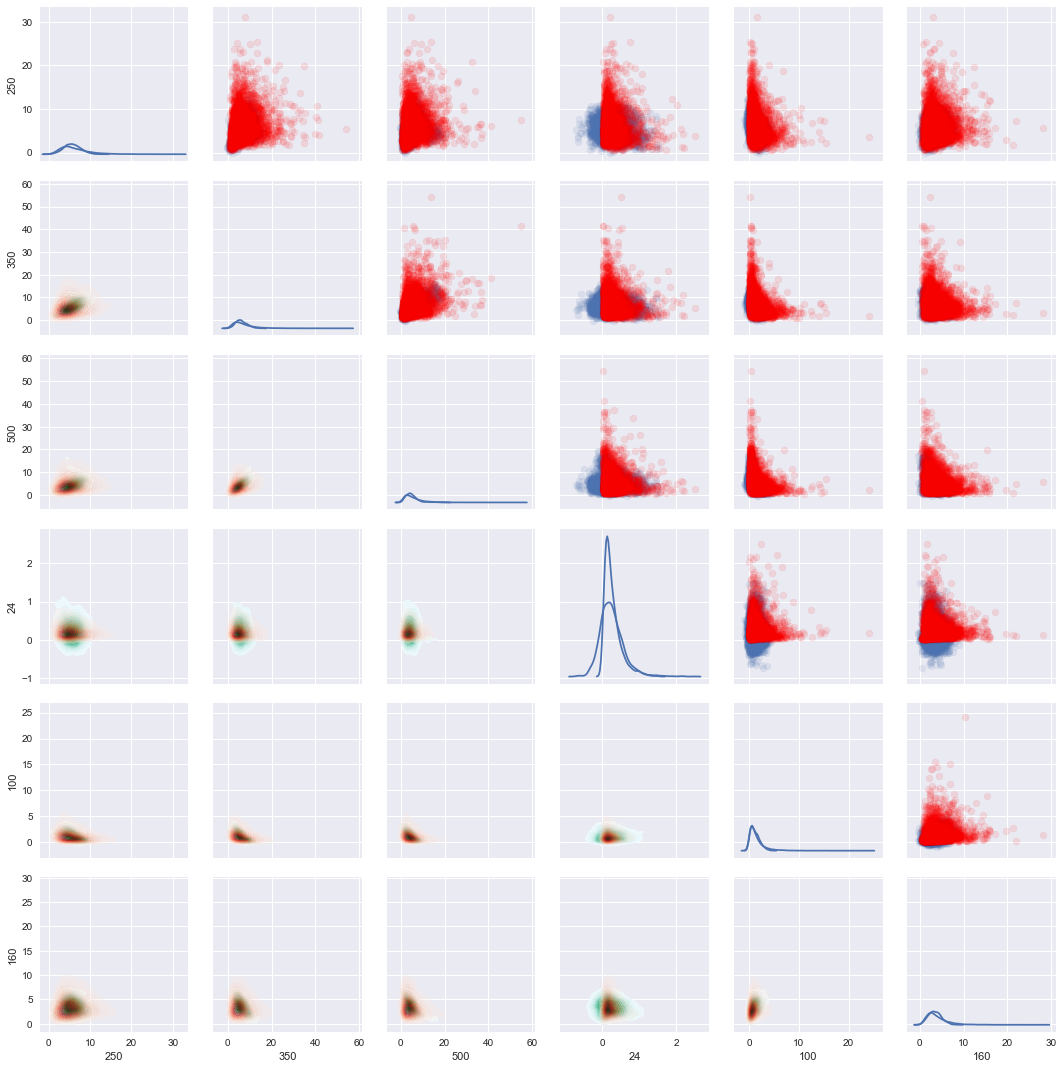

In [83]:
import seaborn as sns
import pylab as plt
%matplotlib inline
g=sns.PairGrid(df)
g.map_diag(sns.kdeplot)
g.map_lower(sns.kdeplot,n_levels=20, shade=True,shade_lowest=False)
g.map_upper(plt.scatter, alpha=0.1)
g.data=pd.DataFrame(np.power(10.0,log_normal),columns=['250','350','500','24', '100', '160'])
g.map_diag(sns.kdeplot)
g.map_lower(sns.kdeplot,n_levels=20, shade=True,shade_lowest=False, cmap="Reds", alpha=0.3)
g.map_upper(plt.scatter, alpha=0.1, color='r')

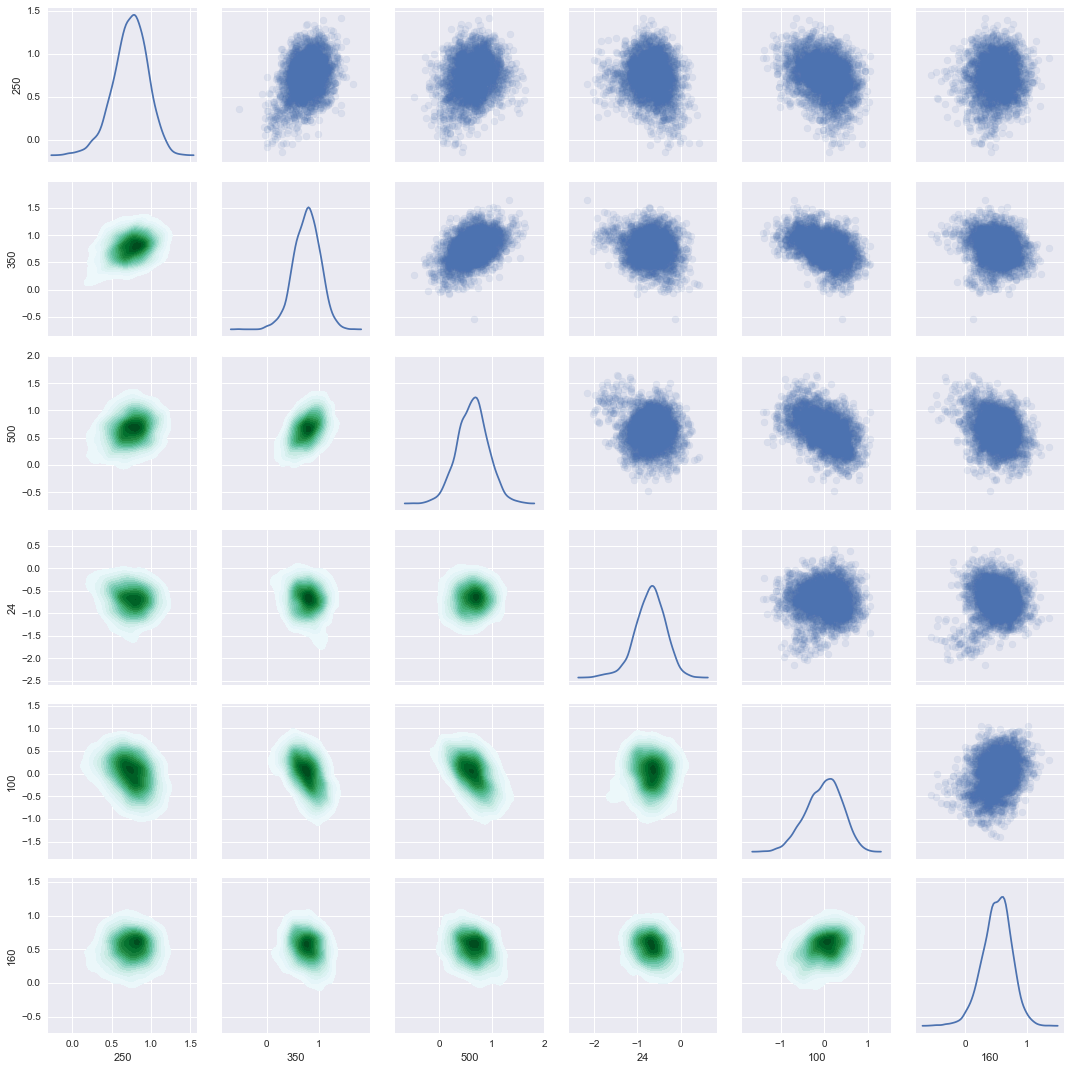

In [64]:
g=sns.PairGrid(pd.DataFrame(log_normal,columns=['250','350','500','24', '100', '160']))
g.map_diag(sns.kdeplot)
g.map_lower(sns.kdeplot,n_levels=20, shade=True,shade_lowest=False)
g.map_upper(plt.scatter, alpha=0.1)

In [50]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
indices                                           


array([[0, 1, 2],
       [1, 0, 2],
       [2, 1, 0],
       [3, 4, 5],
       [4, 3, 5],
       [5, 4, 3]])

In [28]:
SEDs.shape

(32, 6, 800)

In [51]:
sig=np.empty((SEDs.shape[0],SEDs.shape[2]))
for i in range(0,SEDs.shape[2]):
    nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(SEDs[:,:,i])
    distances, indices = nbrs.kneighbors(SEDs[:,:,i])
    sig[:,i]=distances[:,1]

In [ ]:
for i in range(0,SEDs.shape[2]):
    sig[:,i]=0.3*np.std(SEDs[:,0,ind]*10.0**LIR,
        sig[:,i]=0.3*np.std(np.log10(SEDs[:,:,i]*10.0**LIR),axis=0)

In [54]:
LIR=8
sig[0,:]*np.power(10.0,10)

array([  2.84348739e+10,   2.89852761e+02,   7.39912471e+01,
         3.28076832e+01,   1.84215686e+01,   1.18328268e+01,
         8.27184419e+00,   6.08707386e+00,   4.64899418e+00,
         3.66615825e+00,   2.96778394e+00,   2.45399866e+00,
         2.05449490e+00,   1.74368629e+00,   1.50220233e+00,
         1.31623894e+00,   1.16295300e+00,   1.03081403e+00,
         9.17509676e-01,   8.22262017e-01,   7.40674759e-01,
         6.70752248e-01,   6.11260293e-01,   5.61158752e-01,
         5.15448571e-01,   4.74220188e-01,   4.37594705e-01,
         4.05656978e-01,   3.77708809e-01,   3.52824123e-01,
         3.30828331e-01,   3.10742355e-01,   2.92361705e-01,
         2.74746025e-01,   2.58322317e-01,   2.43058547e-01,
         2.29758060e-01,   2.17732475e-01,   2.06540620e-01,
         1.95669097e-01,   1.85435595e-01,   1.76616959e-01,
         1.68405149e-01,   1.60811937e-01,   1.53362109e-01,
         1.46320176e-01,   1.39890665e-01,   1.34135236e-01,
         1.29036046e-01,

In [79]:
sig=np.empty((SEDs.shape[1],SEDs.shape[2]))
for i in range(0,SEDs.shape[2]):
    sig[:,i]=0.3*np.std(np.log10(SEDs[:,:,i]*10.0**LIR),axis=0)

In [70]:
np.save('log10_SED_IR_sig', sig)

In [12]:
np.trapz(df['Blue_SF_glx.norm_LIR'][(df['wave']>8) & (df['wave']<1000)][::-1],x=3.0E8/(df['wave'][(df['wave']>8) & (df['wave']<1000)][::-1]*1E-6))*1E-26/1E4

3.82580418875477e+29

In [13]:
df['wave']

0           0.009100
1           0.009400
2           0.009600
3           0.009800
4           0.010000
5           0.010200
6           0.010400
7           0.010600
8           0.010800
9           0.011000
10          0.011400
11          0.011800
12          0.012100
13          0.012500
14          0.012700
15          0.012800
16          0.013100
17          0.013200
18          0.013400
19          0.013700
20          0.014000
21          0.014300
22          0.014700
23          0.015100
24          0.015500
25          0.015900
26          0.016200
27          0.016600
28          0.017000
29          0.017300
            ...     
10975    1658.999475
10976    1669.000456
10977    1679.000889
10978    1689.000047
10979    1699.000924
10980    1708.999095
10981    1718.999480
10982    1728.999534
10983    1739.000479
10984    1748.999742
10985    1759.000491
10986    1769.000155
10987    1779.000020
10988    1788.999448
10989    1798.999774
10990    1809.000387
10991    1819

In [14]:
template=ascii.read('/Users/pdh21/astrodata/SEDs/Berta2013/templates_berta_norm_LIR/'+temps[0])

In [25]:
np.trapz(template['col2'][(template['col1']>8E3) & (template['col1']<1E6)],x=template['col1'][(template['col1']>8E3) & (template['col1']<1E6)])

0.99065289555174796

In [23]:
template['col1']

90.99999
94.0
95.99999
98.0
100.0
102.00001
104.0
105.99997
107.99998
109.99997
113.99998


In [29]:
print(np.trapz(template['col2'][(template['col1']<8E3)],x=template['col1'][(template['col1']<8E3)]))
print(np.trapz(template['col2'][(template['col1']>8E3) & (template['col1']<1E6)],x=template['col1'][(template['col1']>8E3) & (template['col1']<1E6)]))
print(np.trapz(template['col2'][(template['col1']<1E6)],x=template['col1'][(template['col1']<1E6)]))


0.210849971767
0.990652895552
1.20152082665


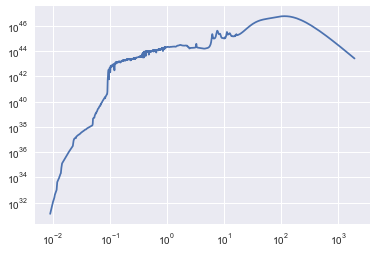

In [17]:
plt.loglog(df['wave'],df['Blue_SF_glx.norm_LIR'])

In [27]:
print(np.trapz(df['Blue_SF_glx.norm_LIR'][(df['wave']>8) & (df['wave']<1000)][::-1]
         ,x=3.0E8/(df['wave'][(df['wave']>8) & (df['wave']<1000)][::-1]*1E-6))*1E-26/1E4)
print(np.trapz(df['Blue_SF_glx.norm_LIR'][(df['wave']<8)][::-1]
         ,x=3.0E8/(df['wave'][(df['wave']<8)][::-1]*1E-6))*1E-26/1E4)

3.82580418875e+29
1.7493619078e+29


2.1954022988505746